In [2]:
from torch.autograd import Variable
import torch
import numpy as np
import torch.nn as nn
import math
import torch.nn.functional as F

# 3 编码器

- 结构
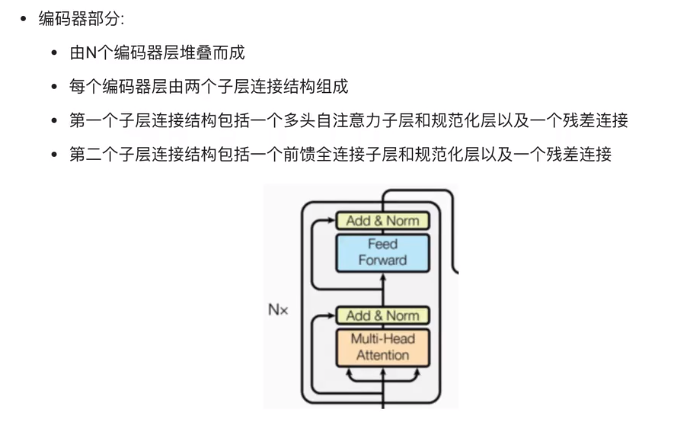

# 3.1 掩码张量

- 什么是掩码张量

元素只有0，1。代表位置看不见和看得见，表现形式是一个张量。

- 作用：

应用在attention。

避免未来信息被提前利用。

——为什么？：理论上解码器不可能一次得到可能的所有结果，而是一次次通过上一次的结果综合得出的，所有再训练时未来的信息可能被提前利用，要进行遮掩。


In [1]:
def subsequent_mask(size):
    '''生成向后遮掩的掩码张量，参数ize是掩码张量最后两个维度的大小，
    它的最后两维形成一个方阵'''
    # 在函数中，首先定义掩码张量的形状
    attn_shape = (1, size, size)
    
    # 然后使用np.ones方法向这个形状中添加1元素,形成上三角阵，最后为了节约空间
    # 再使其中的数据类型变为无符号8位整形unit8
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    
    # 最后将numpy类型转化为torch中的tensor，内部做一个1- 的操作
    # 在这个其实是做了一个三角阵的反转，subsequent_mask中的每个元素都会被1减
    # 如果是8，subsequent_mask中的该位置由0变成1
    #如果是1，subsequent_mask中的该位置由1变成1
    return torch.from_numpy(1 - subsequent_mask)

- 关键代码
    
    - 张量形状：和词嵌入张量维度相同，后两维是方阵，size=d_model
    - 上三角矩阵：np.triu

- 图形化解释
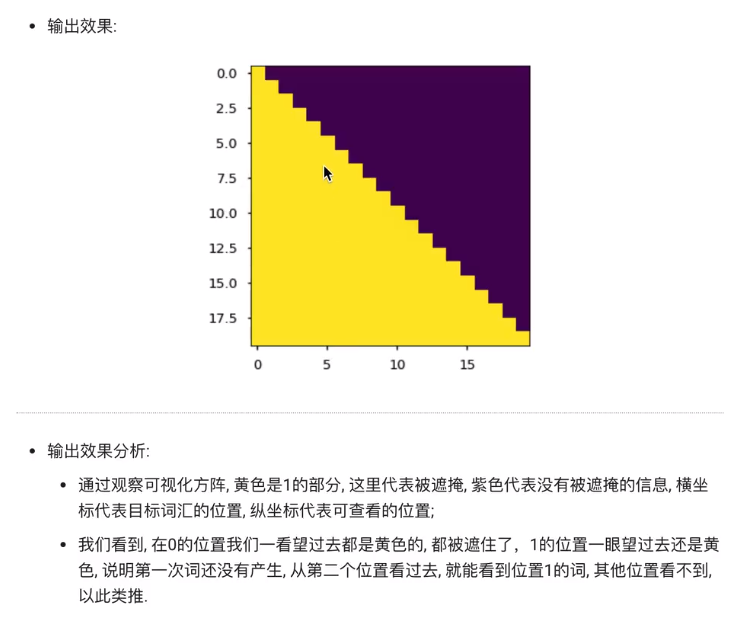

- mask掩码演示

In [ ]:
input = Variable(torch.randn(5,5))
input

tensor([[ 0.6555,  0.5276, -0.1166, -2.0078,  0.0960],
        [-0.2136,  0.3728,  0.7722,  0.4412, -0.3691],
        [ 0.2247, -0.5424, -1.3578,  1.2975, -0.4786],
        [-1.5368,  1.7762, -2.0833, -0.4221, -0.5721],
        [-0.0903, -0.0398,  2.3676, -2.0670, -0.3978]])

In [ ]:
size = 5
attn_shape = (1, size, size)

# 然后使用np.ones方法向这个形状中添加1元素,形成上三角阵，最后为了节约空间
subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
subsequent_mask

array([[[0, 1, 1, 1, 1],
        [0, 0, 1, 1, 1],
        [0, 0, 0, 1, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0]]], dtype=uint8)

In [ ]:
mask = torch.from_numpy(subsequent_mask)
input.masked_fill(mask == 0, -1e9)

tensor([[[-1.0000e+09, -7.9441e-01,  1.1637e+00, -1.0743e+00, -2.6299e-01],
         [-1.0000e+09, -1.0000e+09,  1.3230e+00,  1.1961e+00,  4.1983e-01],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09,  1.9792e+00, -1.3675e+00],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09,  4.0862e-01],
         [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]]])

# 3.2 注意力机制

Scaled Dot-Product Attention

- 计算规则：

需要三个指定的输入Q(query),K(key),V(value),然后通过公式得到注意力的计算结果,

这个结果代表query在key和value作用下的表示

- 注意力计算规则：

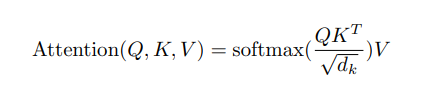

        - d_k 是Q最后一维的大小

- 理解

    - Q：原始文本（比如要翻译的原文本）
    - K：提示
    - V：根据Q、K浮现的答案（大脑对提示K的延申）
        - 所以一般来说，K=V，但与Q不同

- 一般注意力：K=V!=Q，不同于文本的关键词
- 自注意力：Q=K=V，文本自身表达自身，完全通过模型从给定文本提取关键词来表征它（文本）自己，相当于对文本自身的一次特征提取。

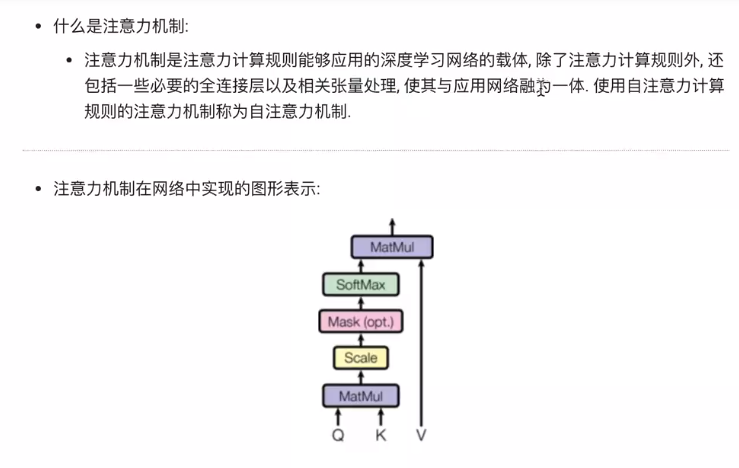

- 代码实现：

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    '''注意力机制的实现,输入分别是query,key,value,
    mask: 掩码张量dropout是nn.Dropout层的实例化对象, 默认为None'''
    # 在函数中,首先取query的最后一维的大小,一般情况下就等同于我们的词嵌入维度,命名为d_k(==d_model)
    d_k = query.size(-1)
    
    # 按照注意力公式,将query与key的转置相乘,
    # 这里面key是将最后两个维度进行转置,再除以缩放系数
    #得到注意力得分张量scores
    scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)
    
    #接着判断是否使用掩码张量
    if mask is not None:
        # 使用tensor的masked_fill方法,将掩码张量和scores张量每个位置一一比较,
        # 如果掩码张量 == 0,则对应的scores张量用-1e9这个值来替换,如下演示
        scores = scores.masked_fill(mask == 0,-1e9)
        # 非常小的数，代表不可能被选中（不被看到）
        
    #对scores的最后一维进行softmax操作,使用F.softmax方法,
    # 第一个参数是softmax对象,第二个参数代表最后一维
    #这样获得最终的注意力张量
    p_attn = F.softmax(scores,dim = -1)
    
    # 之后判断是否使用dropout进行随机置0
    if dropout is not None:
        #将p_attn传入dropout对象中进行丢弃处理
        p_attn = dropout(p_attn)

    # 最后,根据公式将p_attn与value张量相乘获得最终的query注意力表示,同时返回注意力张量
    return torch.matmul(p_attn, value), p_attn

- 关键点：

    - Q、K转置相乘，是保证最后两个维度可以相乘
    - dk==d_mocel
    - softmax操作：是对注意力得分张量的最后一维做，使用F.softmax(scores,dim = -1)——得到最终注意力张量：p_attn
    - query注意力表示，即Attention(Q,K,V)：将p_attn与value张量相乘

- 输入输出的shape

    - Q=K=V: shape[2,4,512]
    - 输出：Attention(Q,K,V)的shape和p_attn的shape也是[2,4,512]

## 3.2总结
注意力计算规则的函数:attention

输入就是Q，K，V以及mask和dropout,mask用于掩码,dropout用于随机置0.

输出有两个,query的注意力表示以及注意力张量

# 3.3 多头注意力机制

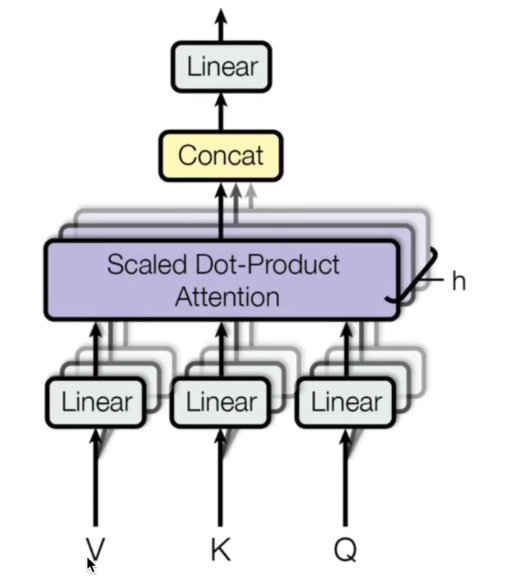

- 多头：

分割词嵌入向量的最后一维（size=d_model=512的那一维）
    
    - 每个头都获得一组Q、K、V，大小是[batch_size, -1, d_model/head]，但是句子中的每个词的表示只获得一部分。
    - 可以理解为句子中每个词的表征都被拆成几个部分，一个头获得句子所有词的部分。
    - 目的：优化每个词的不同特征（512个特征），均衡同一种注意力机制的偏差。

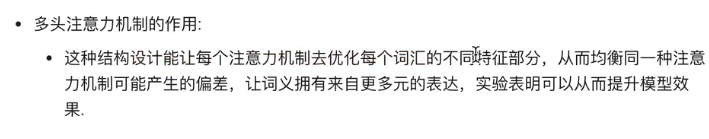

关注到词汇的不同部分
——不同角度看问题



- 代码实现

In [ ]:
#用于深度拷贝的copy工具包
import copy

#首先需要定义克隆函数,因为用到多个结构相同的线性层,
# 我们将使用clone函数将他们一同初始化在一个网络层列表对象中,
def clones(module, N):
    '''用于生成相同网络层的克隆函数,
    它的参数module表示要克隆的目标网络层, N代表需要克隆的数量'''
    # 在函数中,我们通过for循环对module进行N次深度拷贝,使其每个module成为独立的层
    # 然后将其放在nn.ModuleList类型的列表中存放。
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

#实现多头注意力机制的处理
class MultiHeadedAttention(nn.Module):
    def __init__(self, head, embedding_dim,dropout=0.1):
        '''在类的初始化时,会传入三个参数,
        head代表头数,
        embedding_dim代表词嵌入的维度
        dropout代表进行dropout操作时置0比率'''
        super(MultiHeadedAttention, self).__init__()
        
        #在函数中,首先使用了一个测试中常用的assert语句,判断h是否能被d_model整除
        # 这是因为我们之后要给每个头分配等量的词特征.也就是embedding_dim/head个
        assert embedding_dim % head == 8
        
        #得到每个头获得的分割词向量维度d_k
        self.d_k = embedding_dim // head
        
        #传入头数h
        self.head = head
        
        # 然后获得线性层对象,通过nn的Linear实现——线性变换
        # 它的内部变换矩阵是embedding_dim x embed
        #为什么是四个呢,这是因为在多头注意力中,Q,K,V各需要一个,最后拼接的矩阵还需要一个,
        self.linears= clones(nn.Linear(embedding_dim,embedding_dim),4)
        
        # self.attn为None,它代表最后得到的注意力张量,现在还没有结果所以为None
        self.attn = None
        
        # 最后就是一个self.dropout对象
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key,value, mask=None):
        '''输入参数有四个,前三个就是注意力机制需要的Q,K,V,
        最后一个是注意力机制中可能需要的mask掩码张量,默认是None.'''
        #如果存在掩码张量mask
        if mask is not None:
            # 拓展维度,因为多了一个维度：多头中的第n头，在第2个维度添加
            mask = mask.unsqueeze(1)
        
        #接着,batch_size的变量,他是query尺寸的第1个数字,代表有多少条样本
        batch_size = query.size(0)
        
        #进入多头处理环节
        # 首先利用zip将输入QKV与三个线性层组到一起,然后使用for循环,将输入QKV分别传到线性层中（只用到前三个）
        # 做完线性变换后,开始为每个头分割输入,这里使用view方法对线性变换的结果进行维度重塑
        # 这样就意味着每个头可以获得一部分词特征组成的句子,其中的-1代表自适应维度,
        # 然后对第二维和第三维进行转置操作, 为了让代表句子长度维度和词向量维度能够相邻,
        # 这样注意力机制才能找到词义与句子位置的关系,
        #从attention函数中可以看到,利用的是原始输入的倒数第一和第二维.
        query, key,value = \
            [model(x).view(batch_size,-1,self.head,self.d_k).transpose(1,2)
             for model,x in zip(self.linears,(query, key,value))]
        
        #得到每个头的输入后,接下来就是将他们传入到attention中,
        #这里直接调用我们之前实现的attention函数.同时也将mask和dropout传入其中,
        X,self.attn = attention(query, key, value,mask=mask,dropout=self.dropout)
        
        #通过多头注意力计算后,我们就得到了每个头计算结果组成的4维张量,
        # 需要将其转换为输入的形状
        #因此这里开始进行第一步处理环节的逆操作,先对第二和第三维进行转置,
        # 然后使用contiguous，这个方法的作用就是能够让转置后的张量应用view方法,否则将无法直接使用,
        #所以,下一步就是使用view重塑形状,变成和输入形状相同.
        x= x.transpose(1,2).contiguous().view(batch_size,-1,self.head * self.d_k)

        # 最后,将结果传入最后一个线性层,得到最终的多头注意力计算结果
        return self.linears[-1](x)


- unsqueeze示例

In [3]:
input = Variable(torch.randn(5,5))
print(input)
input.unsqueeze(1)
print(input.unsqueeze(1))

tensor([[-0.9053,  0.9648,  0.3541,  0.3977,  0.7630],
        [-1.2941, -0.7101, -0.5367,  1.0342, -1.5880],
        [ 1.8414,  1.3908,  0.0268, -0.7998, -0.2248],
        [-0.2099,  0.9419, -0.8669, -0.5706,  0.4050],
        [ 0.4043,  0.0662,  0.3192, -0.7643, -0.9376]])
tensor([[[-0.9053,  0.9648,  0.3541,  0.3977,  0.7630]],

        [[-1.2941, -0.7101, -0.5367,  1.0342, -1.5880]],

        [[ 1.8414,  1.3908,  0.0268, -0.7998, -0.2248]],

        [[-0.2099,  0.9419, -0.8669, -0.5706,  0.4050]],

        [[ 0.4043,  0.0662,  0.3192, -0.7643, -0.9376]]])


In [4]:
print(input.unsqueeze(0))

tensor([[[-0.9053,  0.9648,  0.3541,  0.3977,  0.7630],
         [-1.2941, -0.7101, -0.5367,  1.0342, -1.5880],
         [ 1.8414,  1.3908,  0.0268, -0.7998, -0.2248],
         [-0.2099,  0.9419, -0.8669, -0.5706,  0.4050],
         [ 0.4043,  0.0662,  0.3192, -0.7643, -0.9376]]])


## 3.3总结

- 多头注意力机制的类: MultiHeadedAttention

    - 是对3.2部分注意力机制的优化
    - 需要使用多个相同的线性层,首先实现了克隆函数clones。
    - clones函数的输入是module，N，分别代表克隆的目标层，和克隆个数。
    - clones函数的输出是装有N个克隆层的Module列表
    - MultiHeadedAttention类 它的初始化函数输入是h,d_model,dropout分别代表头数，词嵌入维度和置零比率
    - 它的实例化对象输入是Q,KV以及掩码张量mask
    - 它的实例化对象输出是通过多头注意力机制处理的Q的注意力表示

# 3.4 前馈全连接层 feed-forward

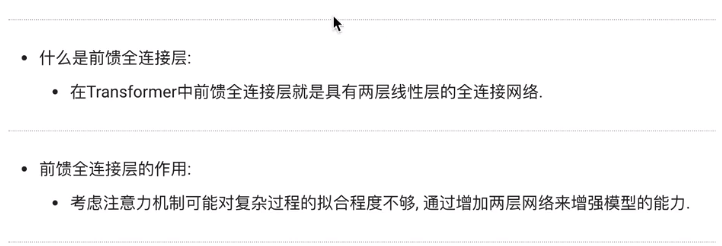

- 代码实现

In [ ]:
#通过类PositionwiseFeedForward来实现前馈全连接层
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model, d_ff,dropout=0.1):
        """初始化函数有三个输入参数分别是d_model,d_ff,和dropout=0.1,
        第一个是线性层的输入维度，因为我们希望保持输入和输出的维度不变,
        第二个参数d_ff就是第二个线性层的输入维度，
        最后一个是dropout置0比率"""
        super(PositionwiseFeedForward, self).__init__()
        
        #nn实例化了两个线性层对象,self.w1和self.w2
        #它们的参数分别是d_model,d_ff和d_ff,d_model
        self.w1 = nn.Linear(d_model. d_ff)
        self.w2 = nn.Linear(d_ff,d_model)
        #然后使用nn的Dropout实例化了对象self.dropout
        self.dropout = nn.Dropout(dropout)
    
    def forward(self,x):
        '''输入参数为X,代表来自上一层的输出'''
        # 首先经过第一个线性层,然后使用Funtional中relu函数进行激活
        #之后再使用dropout进行随机置0,最后通过第二个线性层w2,返回最终结果
        return self.w2(self.dropout(F.relu(self.w1(x))))

- ReLU

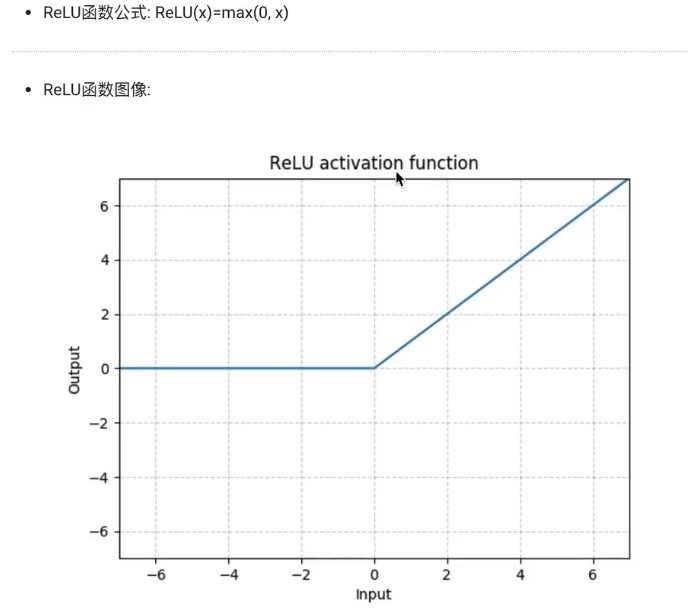

# 3.5 规范化层 Norm

- 规范化层的作用

它是所有深层网络模型都需要的标准网络层，因为随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，

这样可能会导致学习过程出现异常，模型可能收敛非常的慢.因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内

- 代码实现

In [ ]:
# 通过LayerNorm实现规范化层的类
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        '''初始化函数有两个参数,一个是features,表示词嵌入的维度
        另一个是eps它是一个足够小的数,在规范化公式的分母中出现,防止分母为0.默认是1e-6.'''
        super(LayerNorm, self).__init__()
        
        # 根据features的形状初始化两个参数张量a2和b2
        # 第一个初始化为1张量，也就是里面的元素都是1
        # 第二个初始化为0张量，也就是里面的元素都是0
        # 使用nn.Parameter将两个张量转换为模型参数, 代表这两个张量是需要被训练的
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))
        
        # 把eps传到类中
        self.eps = eps
    
    def forward(self, x):
        '''输入参数x代表来自上一层的输出'''
        # 在函数中，首先对输入变量x求其最后一个维度的均值，并保持输出维度与输入维度一致
        # 接着再求最后一个维度的标准差
        # 然后根据规范化公式，用x减去均值除以标准差获得规范化的结果
        # 最后对结果乘以我们的缩放参数，即a2
        # *号代表同型点乘，即对应位置进行乘法操作，加上位移参数b2
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a2 * (x - mean) / (std + self.eps) + self.b2


- 关键：
    - 有需要训练的参数：a2、b2

# 3.6 完整子层连接结构

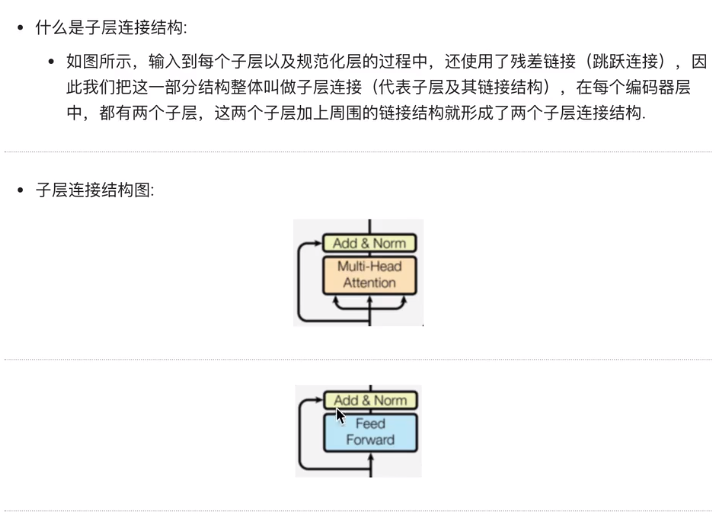

- 代码实现

In [6]:
# 使用SublayerConnection来实现子层连接结构的类
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout=0.1):
        """
        初始化一个SublayerConnection对象。

        参数:
        - size (int): 词嵌入维度的大小。
        - dropout (float, optional): Dropout的概率，默认为0.1。
        """
        
        super(SublayerConnection, self).__init__()
        # 实例化一个LayerNorm对象
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, x, sublayer):
        # 对输出进行规范化
        normalized_x = self.norm(x)
        # 将规范化后的结果传给子层处理
        sublayer_output = sublayer(normalized_x)
        # 对子层输出进行dropout操作
        dropout_output = self.dropout(sublayer_output)
        # 残差连接
        output = x + dropout_output

        # 合起来
        # return x+ self.dropout(sublayer(self.norm(x)))
        return output


# 3.7 完整编码器

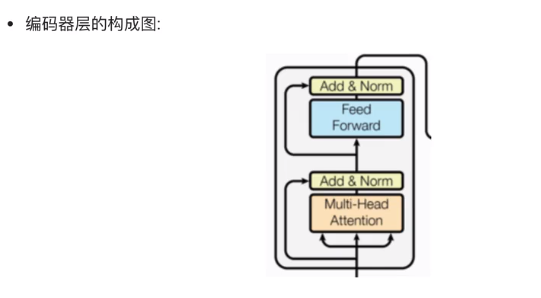

- 代码实现

In [ ]:
# 使用EncoderLayer类实现编码器层
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        """初始化函数参数有四个，分别是size，词嵌入维度的大小，
        self_attn，多头自注意力子层实例化对象，是自注意力
        feed_forward，前馈全连接层实例化对象，
        dropout，置0比率"""
        super(EncoderLayer, self).__init__()
        
        # 将self_attn和feed_forward传入其中
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        
        # 编码器层中有两个子层连接结构，使用clones函数进行克隆
        # SublayerConnection包括一个laynorm和一个残差连接
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        
        # 将size传入其中
        self.size = size
    
    def forward(self, x, mask):
        """forward函数中有两个输入参数，x和mask，分别代表上一层的输出和掩码张量mask。"""
        # 第一个子层，是多头自注意力机制
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        
        # 第二个子层：前馈全连接子层
        return self.sublayer[1](x, self.feed_forward)


# 3.8 N个编码器

- 结构

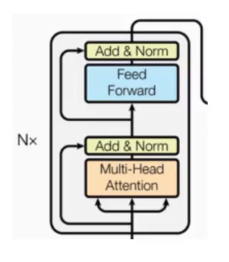

- 代码实现

In [ ]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        """"
        参数:
        - encoder_layer: EncoderLayer类的实例。
        - num_layers: 编码器层数。
        """
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        # Initialize a normalization layer
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        """通过编码器层进行前向传播。
        
        参数:
        - x: 输入张量。
        - mask: 掩码张量。

        过程：每次得到的x是下一次编码器的输入
        
        返回:
        - 经过所有编码器层后的输出张量。
        """
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


In [ ]:
# 完整实现一个编码器逻辑

# Randomly specify the parameters
d_model = 512
d_ff = 2048
dropout = 0.1
num_layers = 6

# Create an instance of the EncoderLayer class
encoder_layer = EncoderLayer(d_model, MultiHeadedAttention(8, d_model), PositionwiseFeedForward(d_model, d_ff), dropout)

# Create an instance of the Encoder class
encoder = Encoder(encoder_layer, num_layers)

batch_size = 32
seq_length = 10

# Call the forward method of the Encoder object
x = torch.randn(batch_size, seq_length, d_model)  # 词嵌入张量
mask = torch.ones(batch_size, seq_length)  # Replace batch_size and seq_length with your desired values
output = encoder(x, mask)
